In [3]:
import os
import matplotlib.pyplot as plt
import numpy as np

import cv2
from PIL import Image
from scipy.stats import gaussian_kde

In [4]:
ROOT_DIR = os.getcwd()

In [5]:
# Function to get the first image from a folder
def get_first_image(folder_path):
    for file in os.listdir(folder_path):
        if file.endswith(".jpg") or file.endswith(".png") or file.endswith(".jpeg"):
            image_path = os.path.join(folder_path, file)
            img = cv2.imread(image_path)
#             img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
            return img

# Function to list folders and get their first images
def get_folders_with_images(base_folder):
    folder_images = []
    for folder in os.listdir(base_folder):
        folder_path = os.path.join(base_folder, folder)
        if os.path.isdir(folder_path):
            first_image = get_first_image(folder_path)
            if first_image.any():
                folder_images.append((folder, first_image))

    # Sort folders based on folder name
    folder_images.sort(key=lambda x: x[0])

    # Return the top six folders
    return folder_images

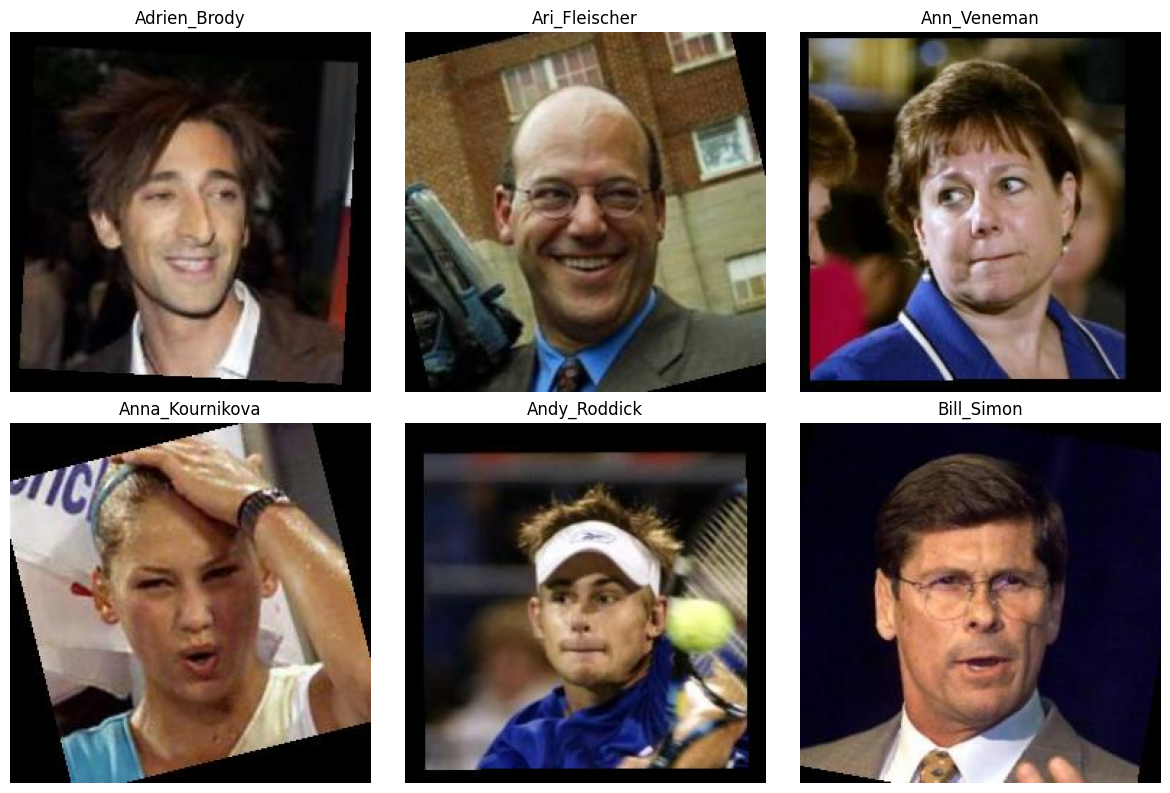

In [6]:
# Set your base folder path here
base_folder = r"C:\Users\HK Joshi\Documents\Github\Biometrics_Assignments\LFW_dataset"

# Get the top six folders with their first images
top_folders_with_images = get_folders_with_images(base_folder)

# Display the images in two rows
num_rows = 2
num_cols = 3
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))

for i, (folder_name, image) in enumerate(top_folders_with_images):
    if i>=6:
        break

    row_idx = i % num_rows
    col_idx = i % num_cols
    ax = axes[row_idx, col_idx]
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    ax.imshow(image)
    ax.set_title(folder_name)
    ax.axis("off")

plt.tight_layout()
plt.show()

In [7]:
def center_compare(center, pixel_list):
    out = []
    for pixel in pixel_list:
#         print(pixel)
        if pixel >= center:
            out.append(1)
        else:
            out.append(0)
    return out

def get_pixel(map, x, y):
    try:
        return map[x, y]
    except IndexError:
        return 0

def binary2decimal(binary_list):
    binary_list.reverse()
    ans = 0
    factor = 1
    for i in binary_list:
        ans += i*factor
        factor*=2
    return ans

In [10]:
def get_lbp_image(gray_img):

    img_lbp = gray_img.copy()
    face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

    try:
        detected_faces = face_cascade.detectMultiScale(gray_img)
        column, row, width, height = detected_faces[0]

        # Cropped image
        c_g_img = gray_img[column:column+width , row :row +height]
        c_lbp_img = img_lbp[column:column+width , row :row +height]

        height, width = c_g_img.shape

        for x in range(0, width):
            for y in range(0, height):
                center = c_g_img[x, y]
                top_left = get_pixel(c_g_img, x-1, y-1)
                top_up = get_pixel(c_g_img, x, y-1)
                top_right = get_pixel(c_g_img, x+1, y-1)
                left = get_pixel(c_g_img, x-1, y)
                right = get_pixel(c_g_img, x+1, y)
                bottom_left = get_pixel(c_g_img, x-1, y+1)
                bottom_down = get_pixel(c_g_img, x, y+1)
                bottom_right = get_pixel(c_g_img, x+1, y+1)

                neighbor_list = [top_left, top_up, top_right, right, bottom_right, bottom_down, bottom_left, left]

                binary_list = center_compare(center, neighbor_list)
                decimal_value = binary2decimal(binary_list)
                c_lbp_img.itemset((x, y), decimal_value)

        # The new image after replacing the pixel with binarized values of surrouding value
        cv2.imwrite('Jiri_Novak_0010_lbp.png', img_lbp)
        new_lbp_img = cv2.imread('Jiri_Novak_0010_lbp.png')
    
    except:
        return None

    return c_lbp_img

Text(0.5, 1.0, 'Cropped Converted lbp grayscale image')

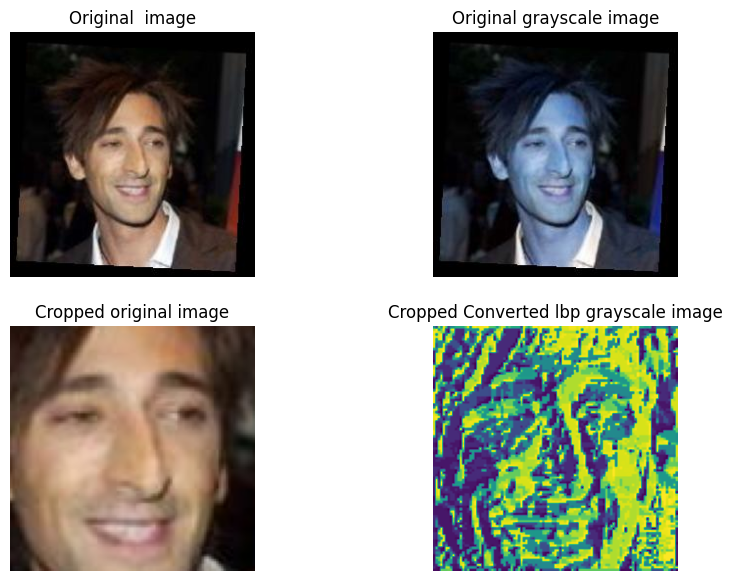

In [25]:
img = top_folders_with_images[0][1].copy()
orig_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
gray_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2GRAY)
img_lbp = get_lbp_image(gray_img.copy())

face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
detected_faces = face_cascade.detectMultiScale(gray_img)
column, row, width, height = detected_faces[0]

c_o_img = orig_img[column:column+width , row :row +height]

# The new image after replacing the pixel with binarized values of surrouding value
cv2.imwrite('Jiri_Novak_0010_lbp.png', img_lbp)
new_lbp_img = cv2.imread('Jiri_Novak_0010_lbp.png')


plt.figure(figsize=(10, 7))

plt.subplot(221)
plt.imshow(orig_img)
plt.axis('off')
plt.title('Original  image')

plt.subplot(222)
plt.imshow(img)
plt.axis('off')
plt.title('Original grayscale image')

plt.subplot(223)
plt.imshow(c_o_img)
plt.axis('off')
plt.title('Cropped original image')

plt.subplot(224)
plt.imshow(img_lbp)
plt.axis('off')
plt.title('Cropped Converted lbp grayscale image')


Text(0.5, 1.0, 'LBP image histogram')

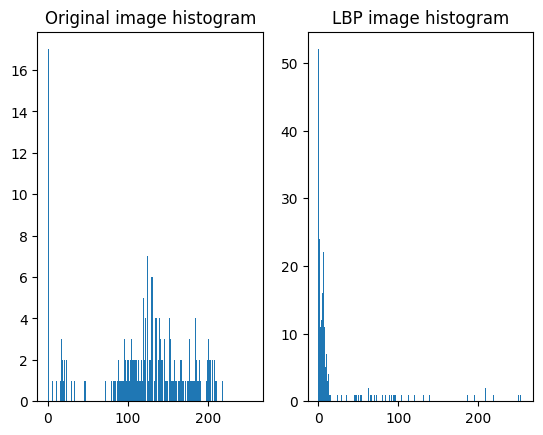

In [26]:
hist, bins = np.histogram(c_o_img.flatten(), bins=256, range=[0,256])
hist_lbp, bins_lbp = np.histogram(img_lbp.flatten(), bins=256, range=[0,256])

cfd = hist.cumsum() #calculate the Cumulative Frequency Distribution
cfd_lbp = hist_lbp.cumsum()

cfd_normalized = cfd * hist.max()/cfd.max()
cfd_lbp_normalized = cfd_lbp * hist_lbp.max()/cfd_lbp.max()

# e = 1e-10
# cfd_normalized = (cfd - cfd.min())/((cfd.max() - cfd.max()) + e)
# cfd_lbp_normalized = (cfd_lbp - cfd_lbp.min())/((cfd_lbp.max() - cfd_lbp.max()) + e)


plt.subplot(121)
plt.hist(hist, bins)
plt.savefig('Jiri_Novak_0010_hist.png')
plt.title('Original image histogram')

plt.subplot(122)
plt.hist(hist_lbp, bins_lbp)
plt.savefig('Jiri_Novak_0010_lbp_hist.png')
plt.title('LBP image histogram')

In [29]:
# Function to calculate cosine similarity between two vectors
def cosine_similarity(vector_a, vector_b):
    dot_product = np.dot(vector_a, vector_b)
    norm_a = np.linalg.norm(vector_a)
    norm_b = np.linalg.norm(vector_b)
    similarity = dot_product / (norm_a * norm_b)
    return similarity

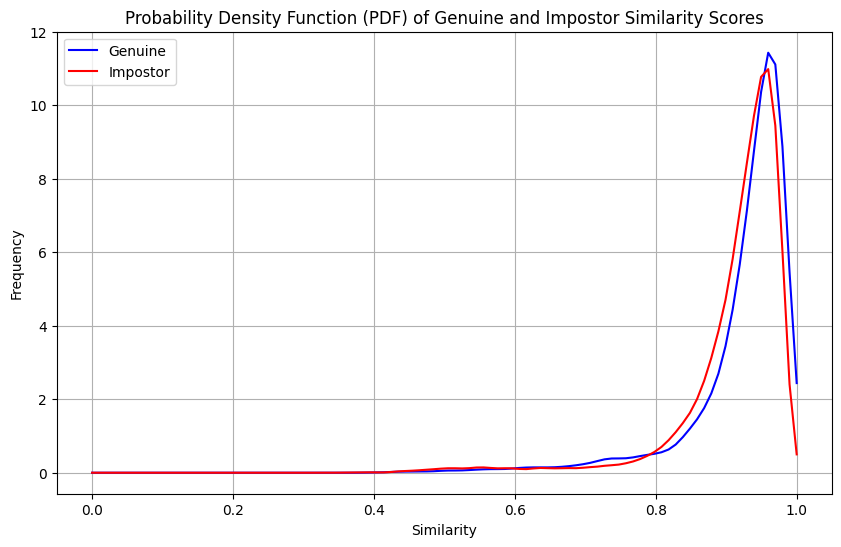

In [28]:
# Path to the folder containing person subfolders
base_folder = os.path.join(ROOT_DIR, 'LFW_dataset')

# Set the similarity threshold
threshold = 0.3

similarity_scores_genuine = []
similarity_scores_impostor = []

# Iterate through each person's folder
person_folders = os.listdir(base_folder)
for i, person in enumerate(person_folders):
    person_path = os.path.join(base_folder, person)
    person_images = os.listdir(person_path)

    for j, image_a in enumerate(person_images):
        image_a_path = os.path.join(person_path, image_a)
        image_a_gray = cv2.imread(image_a_path, cv2.IMREAD_GRAYSCALE)
        image_a_gray = get_lbp_image(image_a_gray.copy())
        if image_a_gray is None:
            continue
        histogram_a = cv2.calcHist([image_a_gray], channels=[0], mask=None, histSize=[256], ranges=[0, 256])
        histogram_a = histogram_a.flatten() / np.sum(histogram_a)  # Normalize the histogram
        
        for image_b in person_images[j + 1:]:
            image_b_path = os.path.join(person_path, image_b)
            image_b_gray = cv2.imread(image_b_path, cv2.IMREAD_GRAYSCALE)
            image_b_gray = get_lbp_image(image_b_gray.copy())
            if image_b_gray is None:
                continue
            histogram_b = cv2.calcHist([image_b_gray], channels=[0], mask=None, histSize=[256], ranges=[0, 256])
            histogram_b = histogram_b.flatten() / np.sum(histogram_b)  # Normalize the histogram
            
            similarity = cosine_similarity(histogram_a, histogram_b)
            similarity_scores_genuine.append(similarity)

    for other_person in (person_folders[:i] + person_folders[i + 1:]):
        other_person_path = os.path.join(base_folder, other_person)
        other_person_images = os.listdir(other_person_path)

        for image_other in other_person_images:
            image_other_path = os.path.join(other_person_path, image_other)
            image_other_gray = cv2.imread(image_other_path, cv2.IMREAD_GRAYSCALE)
#             plt.imshow(image_other_gray)
#             plt.imshow(image_other_gray)
#             print(image_other)
            image_other_gray = get_lbp_image(image_other_gray.copy())
            if image_other_gray is None:
                continue
            histogram_image_other = cv2.calcHist([image_other_gray], channels=[0], mask=None, histSize=[256], ranges=[0, 256])
            histogram_image_other = histogram_image_other.flatten() / np.sum(histogram_b)  # Normalize the histogram
            
            similarity = cosine_similarity(histogram_a, histogram_image_other)
            similarity_scores_impostor.append(similarity)

# Calculate KDE for similarity scores
kde_genuine = gaussian_kde(similarity_scores_genuine)
kde_impostor = gaussian_kde(similarity_scores_impostor)

# Generate range for similarity scores
x = np.linspace(0, 1, 100)

# Calculate frequency using KDE
frequency_genuine = kde_genuine(x)
frequency_impostor = kde_impostor(x)

# Plot PDFs
plt.figure(figsize=(10, 6))
plt.plot(x, frequency_genuine, color='b', label='Genuine')
plt.plot(x, frequency_impostor, color='r', label='Impostor')
plt.title('Probability Density Function (PDF) of Genuine and Impostor Similarity Scores')
plt.xlabel('Similarity')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()
